In [212]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import gaussian_filter


def visualize(arr: np.array, cmap: str = "viridis", flip: bool = False):
    img = np.copy(arr)
    img = img - img.min()
    img = img / img.max()
    plt.imshow(img, cmap=cmap, origin="upper")


def magnitude2(arrX: np.array, arrY: np.array):
    return np.sqrt(arrX**2 + arrY**2)


def interp2d(a, x, y):
    X = np.floor(x).astype(int)
    Y = np.floor(y).astype(int)
    fracX = x - X
    fracY = y - Y
    X = min(max(X, 0), a.shape[0] - 2)
    Y = min(max(Y, 0), a.shape[1] - 2)

    U1 = (1.0 - fracX) * a[X + 0, Y + 0] + fracX * a[X + 1, Y + 0]
    U2 = (1.0 - fracX) * a[X + 0, Y + 1] + fracX * a[X + 1, Y + 1]
    U = (1.0 - fracY) * U1 + fracY * U2
    return U


def diff2(a, x, y):
    h = 1.0
    dadx = (interp2d(a, x + h, y) - interp2d(a, x - h, y)) / (2 * h)
    dady = (interp2d(a, x, y + h) - interp2d(a, x, y - h)) / (2 * h)
    return dadx, dady


d1 = h5py.File("../metsim1_2d.h5", "r")
u = np.array(d1["Velocity"]["X-comp"]).T
v = np.array(d1["Velocity"]["Y-comp"]).T
# u, v = v.T,
img = np.array([u, v, np.zeros_like(u)]).T

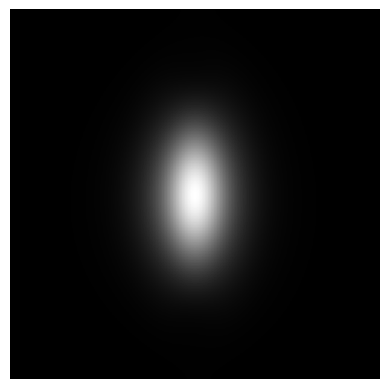

In [213]:
mesh_size = u.shape[0]
dudx, dudy = np.gradient(u, axis=(0, 1))
dvdx, dvdy = np.gradient(v, axis=(0, 1))
vorticity = np.abs(dvdx - dudy)
plt.axis('off')
vorticity = np.pow(gaussian_filter(vorticity, sigma=6), 1)
# add bias
vorticity = vorticity + 0.01*np.max(vorticity)
visualize(vorticity, 'grey')

Max vorticity: 1.5785025358200073
(127, 127)


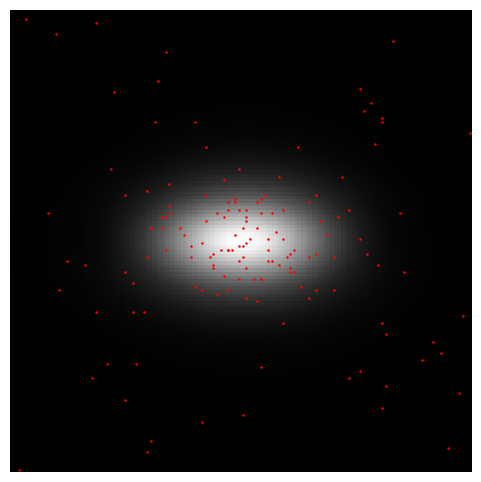

In [ ]:
# pre-processing step done. generate seeds based on vorticity
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_facecolor("black")

num_particles = 150 
T = 100
dt = 0.5
h = dt
steps = int(T / dt)

trajectories = []
lines = []
seeds_x = []
seeds_y = []

max_vorticity = vorticity.max()
print(f"Max vorticity: {max_vorticity}")

# generate PDF from vorticity map
N = vorticity.shape[0]
print(vorticity.shape)
x_coords = np.linspace(0, N, N)
y_coords = np.linspace(0, N, N)

vorticity_flat = vorticity.T.ravel()

probabilities = vorticity_flat / np.sum(vorticity_flat)
sampled_indices = np.random.choice(
    len(vorticity_flat), size=num_particles, p=probabilities
)

sampled_y_idx, sampled_x_idx = np.unravel_index(sampled_indices, vorticity.shape)
seeds_x = x_coords[sampled_x_idx[sampled_x_idx < u.shape[0]]]
seeds_y = y_coords[sampled_y_idx[sampled_y_idx < u.shape[0]]]

visualize(vorticity.T, 'grey')
plt.axis('off')
plt.plot(seeds_x, seeds_y, 'ro', ms=0.8)
plt.savefig("metsim_vorticity_filtered_seeds.eps", bbox_inches='tight', pad_inches=0)

In [215]:
method = "rk4"

for i in range(num_particles):
    pos_x, pos_y = seeds_x[i], seeds_y[i]
    trajectory_x = [pos_x]
    trajectory_y = [pos_y]

    for j in range(steps):
        out_of_bounds = (
            (pos_x < 0)
            or (pos_y < 0)
            or (pos_x >= u.shape[0] - 2)
            or (pos_y >= u.shape[1] - 2)
        )
        if out_of_bounds:
            break
        if method == "euler":
            tmp_x = pos_x

            pos_x += interp2d(u, pos_x, pos_y) * dt
            pos_y += interp2d(v, tmp_x, pos_y) * dt

        elif method == "rk4":
            x0, y0 = pos_x, pos_y
            k0x, k0y = interp2d(u, x0, y0), interp2d(v, x0, y0)
            x1 = x0 + 0.5 * h * k0x
            y1 = y0 + 0.5 * h * k0y
            k1x, k1y = interp2d(u, x1, y1), interp2d(v, x1, y1)
            x2 = x0 + 0.5 * h * k1x
            y2 = y0 + 0.5 * h * k1y
            k2x, k2y = interp2d(u, x2, y2), interp2d(v, x2, y2)
            x3 = x0 + h * k2x
            y3 = y0 + h * k2y
            k3x, k3y = interp2d(u, x3, y3), interp2d(v, x3, y3)
            pos_x = x0 + (h / 6) * (k0x + 2 * k1x + 2 * k2x + k3x)
            pos_y = y0 + (h / 6) * (k0y + 2 * k1y + 2 * k2y + k3y)
            

        trajectory_x.append(pos_x)
        trajectory_y.append(pos_y)

    trajectories.append((trajectory_x, trajectory_y))

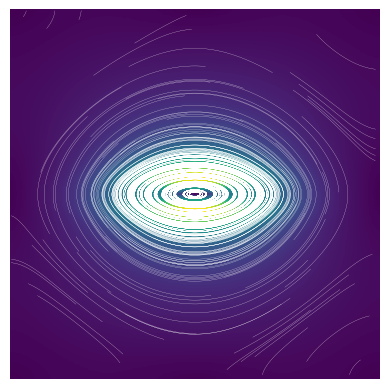

In [ ]:
plt.axis('off')
visualize(magnitude2(u, v).T)
for i in range(len(trajectories)):
    plt.plot(trajectories[i][0], trajectories[i][1], 'w', linewidth=0.15)
plt.savefig("metsim_vorticity_filtered.eps", bbox_inches='tight', pad_inches=0)